<a href="https://colab.research.google.com/github/Huertas97/GenAI-FashionMNIST/blob/main/notebooks/AHG_GenAI_FashionMNIST_Conditional_UNet_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GenAI FashionMNIST Challenge



*   Author: Álvaro Huertas García
*   Contact:
  * GitHub: [Huertas97](https://github.com/Huertas97)
  * Gmail: ahuertasg01@gmail.com



Reference List of Sources used:

- https://wandb.ai/capecape/train_sd/reports/How-to-Train-a-Conditional-Diffusion-Model-from-Scratch--VmlldzoyNzIzNTQ1

- https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit2/02_class_conditioned_diffusion_model_example.ipynb

- https://github.com/zalandoresearch/fashion-mnist

- https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/


- (strongly recommended for a gently but complete  introduction learning)
  - https://jalammar.github.io/illustrated-stable-diffusion/
  - https://huggingface.co/blog/annotated-diffusion

## Outline

- Overview
- Setup
- FashionMNIST Dataset Analysis

## Overview

In this Notebook I am going to:
*  explore the FashionMNIST dataset
*  create **from scratch** and train a class-conditioned UNet model using Pytorch and Diffuser library from HuggingFace
* Evaluate the model using MSE loss
* Test the conditioned generation capabilities of the model

### **What is UNet?**

Something to make clear is the distintion of UNet model, and diffusion process.

UNet is a deep neural network model that was originally introduced in the computer vision field initially for image segmentation, specifically biomedical images ([Paper Link](https://arxiv.org/abs/1505.04597)).

The architecture of UNet conssits of a symmetric architecture with convolutional and pooling layers for downsampling, and then upsampling the image, with skip connections between the symmetric layers. In other words, UNet is an image autoencoder.

On the other hand, Diffusion, that are commonly find in the literatue as "Diffusion models", englobe models that gradually add noise to the original data in the forward diffusion process and then learning to remove the noise in the reverse diffusion process, also named denoising.

UNet can belong to the "diffusion models" category as it can be trained using the diffusion approach to exploit the latent variable extraction autoencoder capabilities of UNet architecture to predict noise of a image, and iteratively remove it to obtain after certain number of step a denoised generated image.
<br>

### **What is a conditional UNet model?**

Solely UNet model are unconditioned models as they do not include any other information during the training/inference phase, as they just provide the expected noise of an image that can be removed form an original noisy image untill finally obtaining the generated image. So this process lacks of guidance or control just relying on the input noisy image.

However, Conditional UNet is a variant of the UNet model that incorporates additional conditional information into the network, so we can explit the capability of adding information during the denoising process where we expect the model to learn how to predict noise to be removed conditioned to the information passed alongside an input image.

In our case, the information will be the class label of the FashionMNIST. Thus, the Conditonal UNet model can be controlled to create a image of an specified class.



Btw: If our scenario required conditioning the output image, with an image instead of the class label, we could have use ControlNet.

Once we have a bit background and organized our ideas, let's jupm to the fun part of coding.


## Notebook Setup

In [8]:
%pip install -qq diffusers icecream torch-summary

In [9]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from collections import Counter
from icecream import ic
ic.configureOutput(prefix='DEBUG -> ') # helpful for debugging instead of print
import torchsummary


device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


## FashionMNIST Dataset Analysis


FashionMNIST consists of clothes images assigned to one of the following labels ([GitHub Link](https://github.com/zalandoresearch/fashion-mnist)):

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [5]:
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader

# Load the dataset
dataset = torchvision.datasets.FashionMNIST(root="fashionmnist/",
                                            train=True,  # download the train split
                                            download=True,
                                            transform=torchvision.transforms.ToTensor())


# Show info about dataset
dataset

100%|██████████| 26421880/26421880 [00:14<00:00, 1879462.72it/s]


Extracting fashionmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashionmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 139608.47it/s]


Extracting fashionmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashionmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 1091964.92it/s]


Extracting fashionmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashionmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12062724.58it/s]


Extracting fashionmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashionmnist/FashionMNIST/raw



Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: fashionmnist/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
# Create a exploratory dataloader (batch size 8 for showing 8 images)
eda_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Class names for FashionMNIST
class_labels_names = ["T-shirt/top", "Trouser", "Pullover",
                "Dress", "Coat", "Sandal", "Shirt", "Sneaker",
                "Bag", "Ankle boot"]

# Loop through the dataset, collect: image n channels, height and witdh, labels
labels = []
image_sizes = []
image_n_channels = []
color_distributions = []
for image, label in tqdm(dataset, desc="Loading labels and extracting images"):
    # RGB channels
    image_n_channels.append(image.shape[0])

    # Resolution
    image_sizes.append((image.shape[1], image.shape[2]))

    # Labels
    labels.append(label)

    # Color distribution scaled of the image
    pixel_values = (image * 255).flatten().numpy().astype(int)
    color_distribution = np.bincount(pixel_values, minlength=256)
    color_distributions.append(color_distribution)

## Version with comprehension list
# dataset_info = [(image.shape[0], (image.shape[1], image.shape[2]), label) for image, label in
#                 tqdm(dataset, desc="Dataset looping")]
# image_n_channels, image_sizes, labels = zip(*dataset_info)

print(f"Distribution of number of RGB Channels: {Counter(image_n_channels)}")
print(f"Distribution of Resolution (image size in px): {Counter(image_sizes)}")
print(f"Distribution of labels: {Counter(labels)}\n")

Loading labels and extracting images:   0%|          | 0/60000 [00:00<?, ?it/s]

Distribution of number of RGB Channels: Counter({1: 60000})
Distribution of Resolution (image size in px): Counter({(28, 28): 60000})
Distribution of labels: Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})



* We have a dataset of 60,000 images, each with a resolution of 28x28px and a single RGB channel.

* The images are divided into 10 classes, with each class represented uniformily by 6k instances.

For the sake of showing some visualization, even thogh we have gathered the most important details about the dataset, we are going to proceed with some visualization that could be useful for other complex datasets.

#### Visualize images in the dataset with the labels

Here we will see the size (pixels), and the RGB channels of the images.

Image input shape: torch.Size([8, 1, 28, 28])
Labels: [3 0 8 1 0 0 0 2]


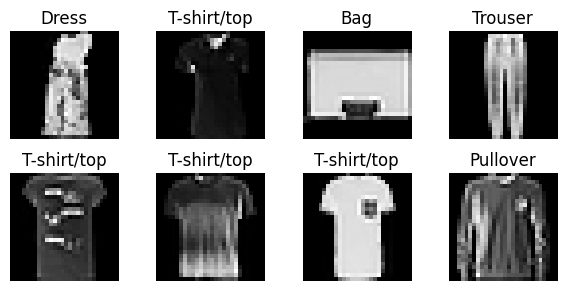

In [ ]:
# Get examples from the dataloader
x, y = next(iter(eda_dataloader))
print('Image input shape:', x.shape) # [batch, RGB channels, height, witdh]
print('Labels:', y.detach().numpy())

# Create a grid of images with their labels
fig, axs = plt.subplots(2, 4, figsize=(6, 3))
for i, (img, label) in enumerate(zip(x, y)):
    ax = axs[i // 4, i % 4]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(class_labels_names[label.item()])
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Plotting Histogram of Image Sizes

Here we check visually all the images have the same size (28x28px = 784 px).

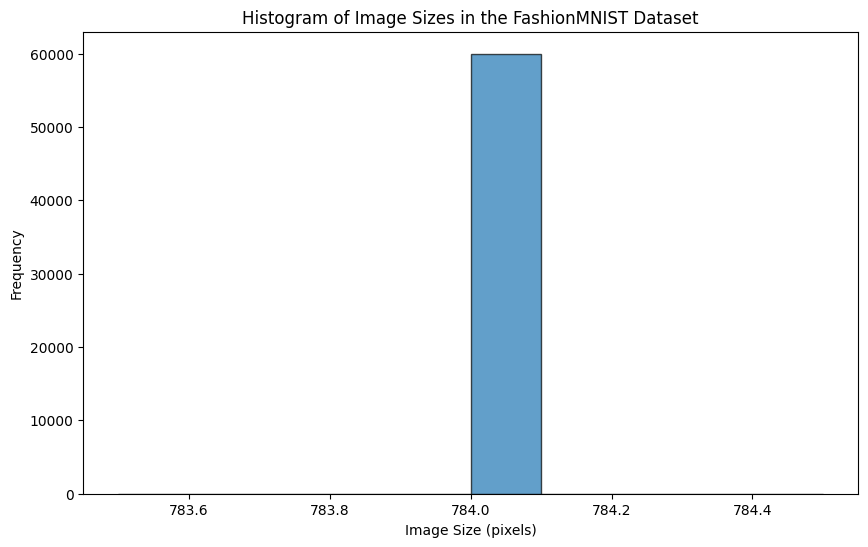

In [ ]:
# Extract image sizes (all 28x28 for FashionMNIST)
image_sizes = [image.shape[1] * image.shape[2] for image, _ in dataset]

# Plotting histogram of image sizes
plt.figure(figsize=(10, 6))
plt.hist(image_sizes, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Image Size (pixels)')
plt.ylabel('Frequency')
plt.title('Histogram of Image Sizes in the FashionMNIST Dataset')
plt.show()

#### Visualizing the Distribution of Images

Visually checking that there is no imbalance, as all classes have 6.000 data instances.

The imbalanced distribution can affect on how the conditional UNet model struggle to generate some classes intead of another.

In case it was imbalanced, we would need to consider some techcniques for helping the model to equitative learn across all the classes (e.g. oversampling, undersampling, weighted loss).

In [ ]:
# Visualize the distribution of images in the dataset

# Prepare the x (class names) and y (frequency) data to plot
labels_sorted, freq = zip(*(Counter(labels)).items()) # sorted by Counter
class_labels_sorted = [class_labels[i] for i in labels_sorted] # from int to class name

# Plotly figure
fig = go.Figure()

fig.add_trace(go.Bar(
    x=class_labels_sorted,
    y=freq,
    marker_color='royalblue'
))

fig.update_layout(
    title='Distribution of Images in the FashionMNIST Dataset',
    xaxis_title='Class',
    yaxis_title='Frequency'
)

fig.show() # in GitHub it will not be displayed

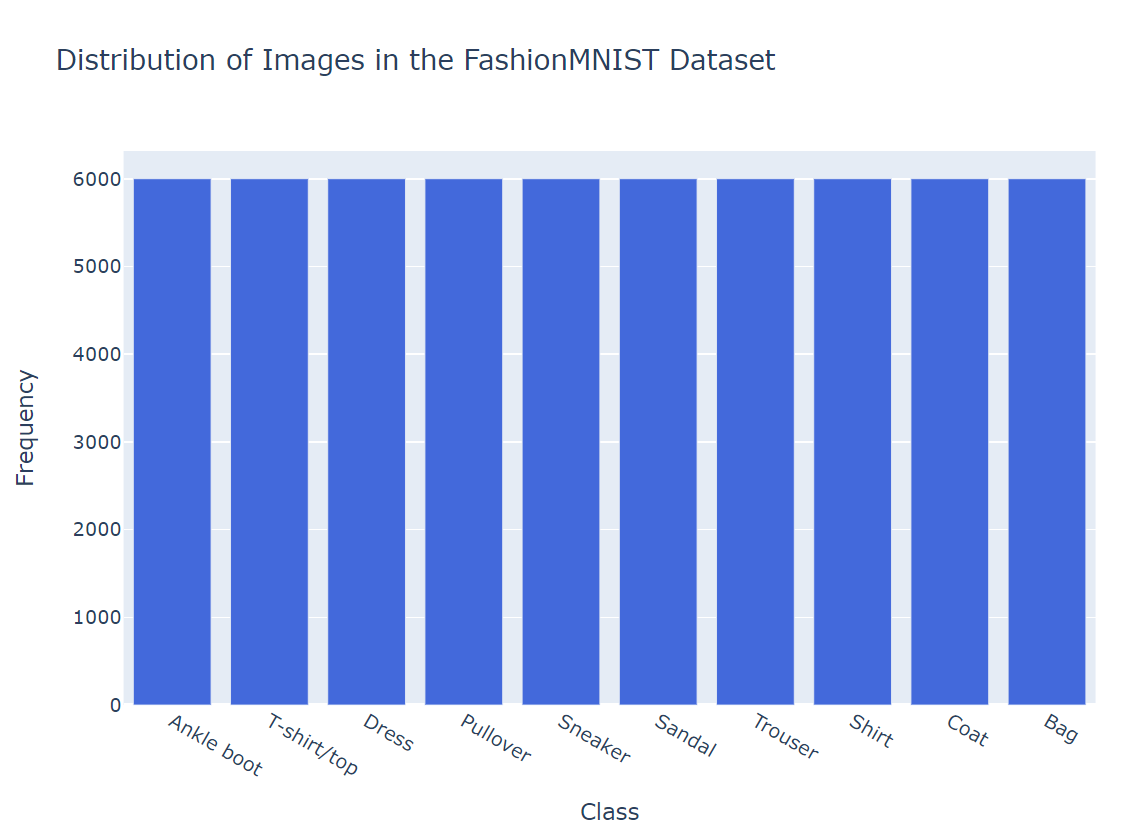

#### Scatter Plot of Image Resolutions

We already know that all images are 28x28 px. However with this code we would make a scatterplot to check it visually.

Honestly, it would be most usefull in a more complex dataset where images have different sizes. Then, we would know how to sclae them to mantain an uniform size across all the dataset to be fed into the model.

In [ ]:
import plotly.express as px

# Create a scatter plot for image resolutions
fig = px.scatter(x=np.array(image_sizes)[:, 0], y=np.array(image_sizes)[:, 0],
                 labels={'x': 'Width (pixels)', 'y': 'Height (pixels)'},
                 title='Scatter Plot of Image Resolutions in the FashionMNIST Dataset')

fig.show()

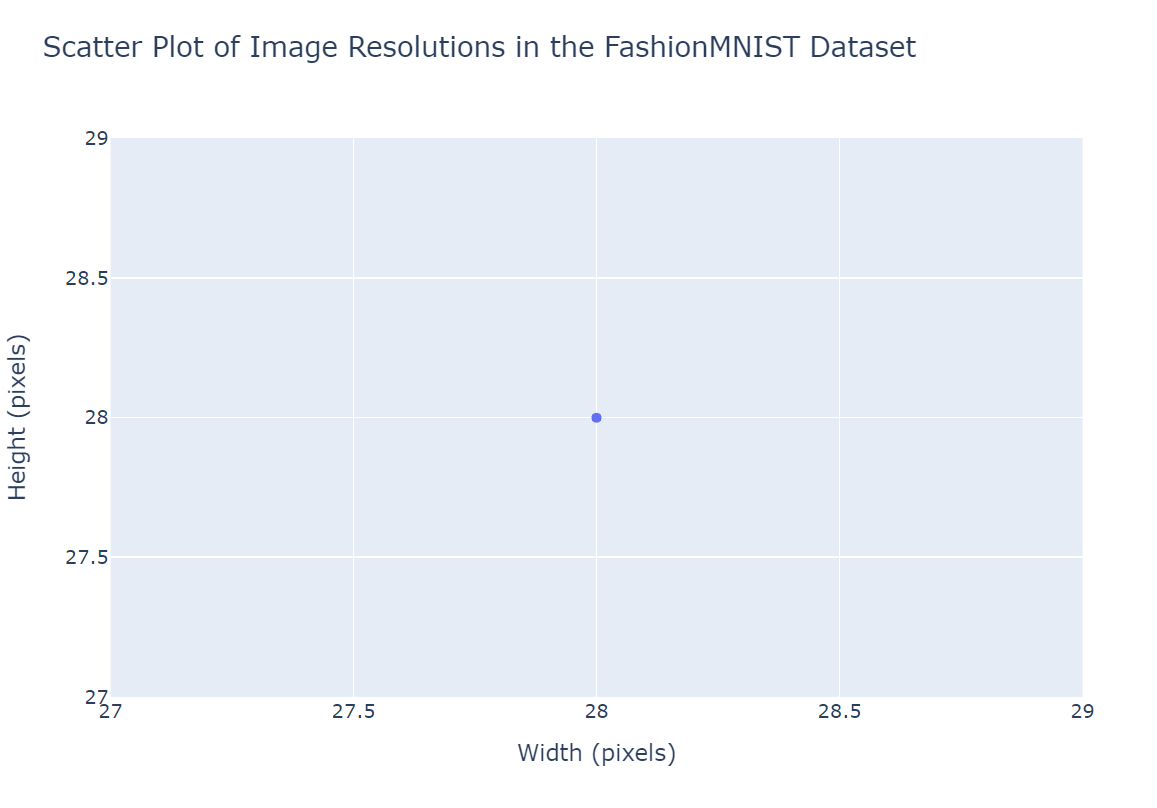

#### Mean Color Distribution

In [ ]:
# Mean color distribution of the images of the dataset
fig = px.bar(x=np.arange(256), y=np.mean(color_distributions, axis=0),
             labels={'x': 'Pixel Intensity', 'y': 'Frequency'},
             title='Mean Color Distribution of the Dataset (one RGB channel)')

fig.show()

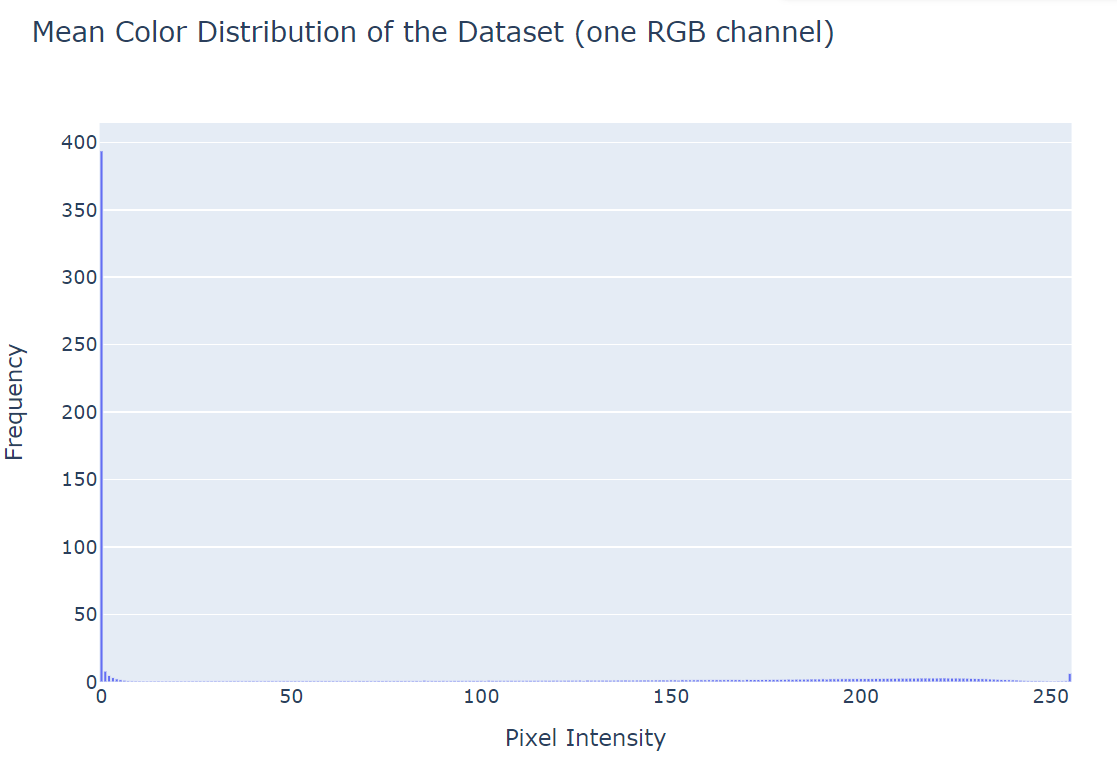

## UNet Implementation (conditional UNet)

Clearly, this code is inspired by the HuggingFace Diffusers course [link](https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit2/02_class_conditioned_diffusion_model_example.ipynb#scrollTo=C4YOLrfs2cTF).

However, I explain some details and things to consider about the model architecture.


* First, I use two residual connections (ResNet) in each UNet block (paramter `layers_per_block`) instead of just one, trusting the good practices and recommendations of the literature that indicates this configuration intends to address the potential overfitting from the model's complexity and improve how the gradient flow [paper](https://arxiv.org/abs/2312.09608).  

* Secondly, `AttnDownBlock2D` and `AttnUpBlock2D` blocks apply self-attention mechanism for a better spatial information learning. In the downsampling, the initial layers have "poor" information extracted in the features as these are the initial layers, and as we move deeper in the UNet model we extract more information. So, applying attention mechanism enhance the extracted information in this downsampling encoding process. In the upsampling process, attention enhance spatial information but working at the the resiudal connection's (skip connections) level. Attention applied to the skip connection allows the model to learn by focusing more on the important spatial information and suppressing activations at irrelevant regions. Nevertheless, full self-attention is quadratic so it has memory limitations.  



In [6]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # output image resolution. Equal to input resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond
        out_channels=1,           # the number of output channels. Equal to input
        layers_per_block=2,       # two residual connections (ResNet) per block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Forward method takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    bs, ch, w, h = x.shape # x is shape (bs, 1, 28, 28)

    # class conditioning embedding to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # class_cond final shape (bs, 4, 28, 28)

    # Model input is now x and class cond concatenated together along dimension 1
    # We need provide additional information (the class label)
    # to every spatial location (pixel) in the image. Not changing the original
    # pixels of the images, but adding new channels.
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    # with image output size
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [39]:
model = ClassConditionedUnet()

# Dummy input for forward pass for torchsummary to estimate size
x = torch.randn(1, 1, 28, 28)     # Dummy input for image
t = torch.tensor([0.5])           # Dummy timestep
class_labels = torch.tensor([0])  # Dummy class label
dummy_input = (x, t, class_labels)

# model summary (condensed view)
_ = torchsummary.summary(model,
                        #  input_data=dummy_input,
                         device='cpu')

# model summary (expanded view with forward pass)
print(f"\n\n{'-'*50} \n\n")
_ = torchsummary.summary(model,
                         input_data=dummy_input,
                         device='cpu', )

Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         40
├─UNet2DModel: 1-2                       --
|    └─Conv2d: 2-1                       1,472
|    └─Timesteps: 2-2                    --
|    └─TimestepEmbedding: 2-3            --
|    |    └─Linear: 3-1                  4,224
|    |    └─SiLU: 3-2                    --
|    |    └─Linear: 3-3                  16,512
|    └─ModuleList: 2-4                   --
|    |    └─DownBlock2D: 3-4             54,752
|    |    └─AttnDownBlock2D: 3-5         218,816
|    |    └─AttnDownBlock2D: 3-6         198,272
|    └─ModuleList: 2-5                   --
|    |    └─AttnUpBlock2D: 3-7           470,080
|    |    └─AttnUpBlock2D: 3-8           449,536
|    |    └─UpBlock2D: 3-9               112,640
|    └─UNetMidBlock2D: 2-6               --
|    |    └─ModuleList: 3-10             16,768
|    |    └─ModuleList: 3-11             164,736
|    └─GroupNorm: 2-7                    64
|    └─SiLU: 2-8       

## Noise Schedulers

As quite intuitively states the HuggingFace [documentation](https://huggingface.co/docs/diffusers/v0.29.2/en/api/schedulers/overview#diffusers.SchedulerMixin)



> Depending on the context, a scheduler defines how to iteratively add noise to an image or how to update a sample based on a model’s output:
- during training, a scheduler adds noise (there are different algorithms for how to add noise) to a sample to train a diffusion model
- during inference, a scheduler defines how to update a sample based on a pretrained model’s output


---

Among the different parameters in the noise scheduler (alpha, alpha bar, beta, beta bar, etc), all are directly related with beta.

* Beta ($\beta$), in a sense, detemrines the amount o noise we aim to add at each step.
* Hence, being alpha ($\alpha$) the reamining original information after adding noise.

So, it is crucial to carefully select values for betas, the starting and ending values, and how are they applied across the learning timesteps (i.e., how it is sampled).

### Sampling





Relate to this, there are different sampling methods. In Hugginface Diffuser library for the DDPM scheduler:
* linear,
* scaled_linear
* squaredcos_cap_v2

I will use cosine sampling. In my experience with scheduling the learning rate of other models that I have trained, and what I have seen in the literature, cosine avoid the plateau from linear sampling (plateau observed at the beggining,and a bigger one at the end). This linear sampling could apply insufficient noise or become excessively noisy. For the sake of explainability, I attach a comparison of how each scheduler apply noise across the timesteps:

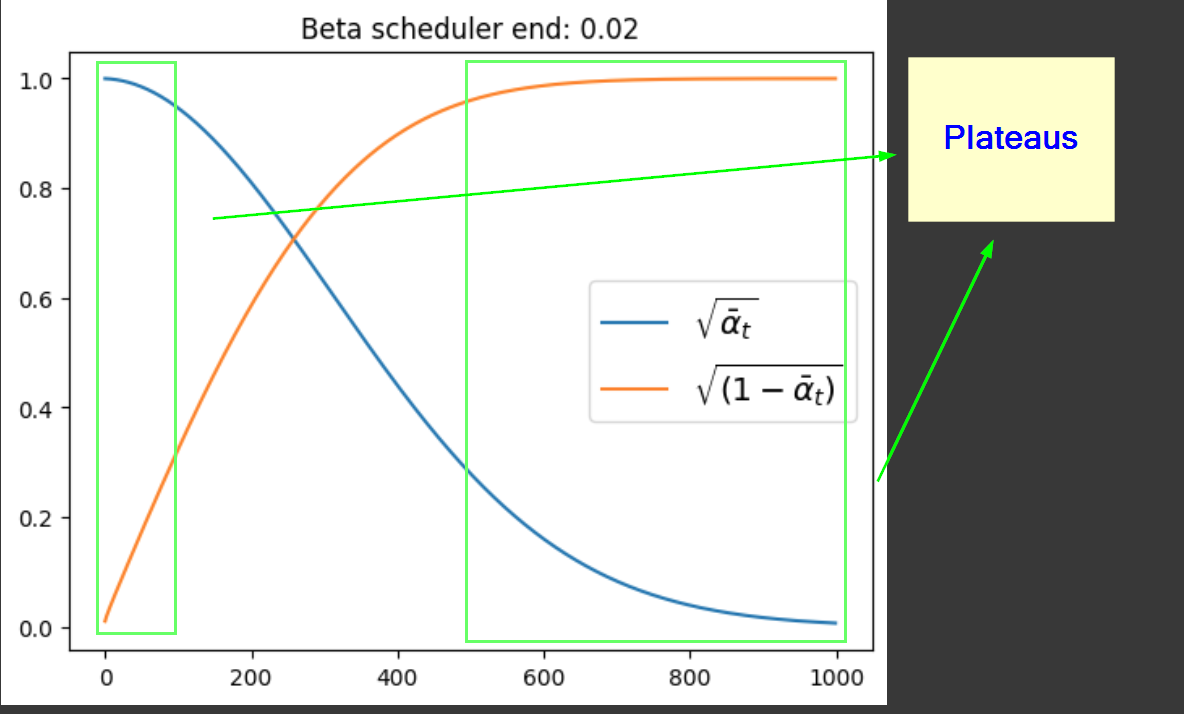

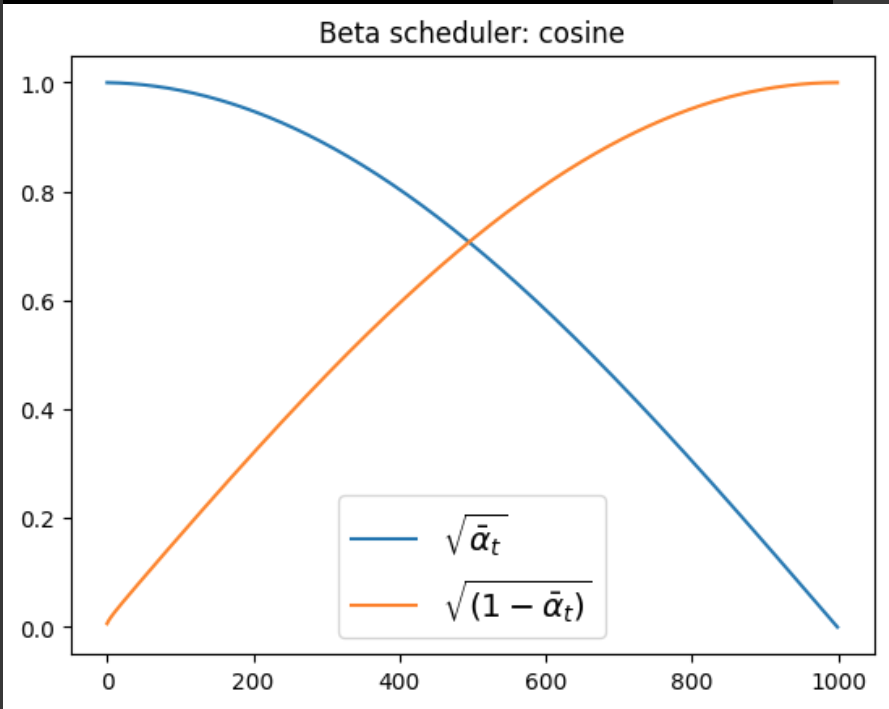

We can see that cosine sampling provides a smoother and more consistent addition of noise. Wich as a first attempt seems more preferible.

In [41]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

## Training Loop

## TODO - Continue researching

- As interestingly [paper](https://arxiv.org/abs/2312.09608) suggests that the UNet's encoder (downsampling part) remains largely unexplored.  It mentions that while the encoder features change gradually, the decoder features exhibit significant variations across different time-steps.
So, it opens the door to play with the encoder. One potential approach is to omit the encoder at certain adjacent time-steps and cyclically reuse encoder features from previous time-steps in the decoder. This could reduce computational overhead and speed up the image generation process during inference.

- The previous point, suggests to me that playing with the feature in the latent space before passing them to the decoder could be quite interesting. Experimenting with different transformations or augmentations of these latent features could potentially enhance the model's performance and the quality of generated images. Or even trying to apply techniques to generate higher resolution outputs than the inputs (quite challenging but useful becuase 28x28 px images are not handy for hummans).

- Even though in the courses referenced and different examples in the literature, use Mean Square Error (MSE) as the loss for training the model, we should try other losses.

 - For example, it seems to me quite clear that Kullback-Leiber (KL) Divergence is a suitable choice. It is used in other techniques (e.g., T-SNE), and it is quite useful in this scenario since, as an overview, KL Divergnce measures the difference between two probability distribution. In this diffusion problem, it would be the distribution predicted by the model and the expected distribution of the noise applied. This relates closely with the initial point about the encoder, because this loss would require that the encoder's latent space embeddings adheres to a probabilistic distribution. This, at my point of view have benefits like robustness & generalization, certainty in the model's predictions & interpretability.  

- It is a no brainer: explore different noise schedulers. A really nice explanation, with cons and pros of a broad variety of schedulers can be found in Stable Diffusion [blog](https://stable-diffusion-art.com/samplers/).

- For sake of practicality, I have used the blocks provided by Diffusers, which are more handy but less configurable. I mention that, becuase we could:
   * Explore the use of Rotary Position Embedding ([ROPE](https://arxiv.org/abs/2104.09864)) technique for possitional encoding, instead of the sinusoidal position embeddings (`SiLU` in the torchsummary) for the timestep positional embeddings. In short, ROPE combines absolute and relative position so can help the model to better understandt the noise level at each timestep (absolute position) with a sense of the surrounding noise timesteps (relative position). The straightfoward implication will be in faster convergence during training, but perhaps could lead also to better results or faster inference as we can skip some denoising timesteps.
